In [2]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<h2>Prioritized Replay Buffer</h2>

<p>Prioritized Experience Replay: https://arxiv.org/abs/1511.05952</p>

In [56]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)  # 以概率分布P进行采样, 得到优先级从大到小的索引
        samples = [self.buffer[idx] for idx in indices]  # 根据索引取出优先级从高到低的样例
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()  # normalize weights
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

In [57]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

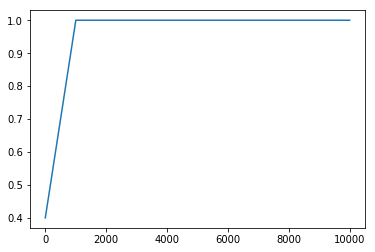

In [58]:
plt.plot([beta_by_frame(i) for i in range(10000)])

<h2>Cart Pole Environment</h2>

In [59]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [60]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

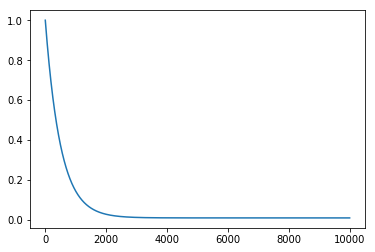

In [61]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [62]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
            return action

In [63]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = NaivePrioritizedBuffer(100000)

<h3>Synchronize current policy net and target net</h3>

In [64]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [65]:
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [75]:
def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta) 

    state      = torch.FloatTensor(np.float32(state)).to(DEVICE)
    next_state = torch.FloatTensor(np.float32(next_state)).to(DEVICE)
    action     = torch.LongTensor(action).to(DEVICE)
    reward     = torch.FloatTensor(reward).to(DEVICE)
    done       = torch.FloatTensor(done).to(DEVICE)
    weights    = torch.FloatTensor(weights).to(DEVICE)
    
    # 这里还是用DDQN的方式
    q_values      = current_model(state)
    next_q_values = current_model(next_state)  # 由当前网络算出下一个状态的Q值
    next_q_state_values = target_model(next_state) 

    q_value      = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1) # 选取最大的Q值
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    delta = expected_q_value - q_value
    
    loss  = (delta.pow(2)* weights).mean()
    optimizer.zero_grad()
    loss.backward()
    
    prios = abs(delta) + 1e-5
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()
    
    return loss

In [76]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

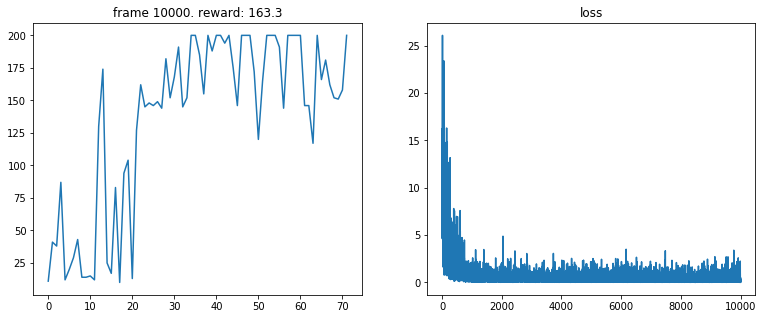

In [77]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)

<p><hr></p>

<h1>Atari Environment</h1>

In [78]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [79]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [80]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(DEVICE)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
            return action

In [81]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(DEVICE)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n).to(DEVICE)
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer  = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

<h3>Epsilon greedy exploration</h3>

In [82]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

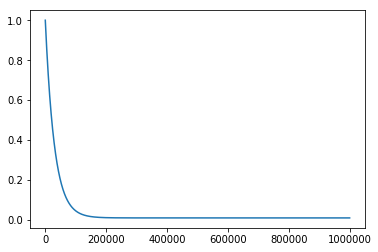

In [83]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

<h3>Beta Prioritized Experience Replay</h3>

In [84]:
beta_start = 0.4
beta_frames = 100000
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

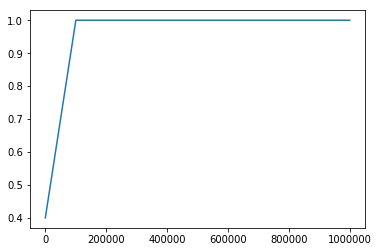

In [85]:
plt.plot([beta_by_frame(i) for i in range(1000000)])

<h3>Training</h3>

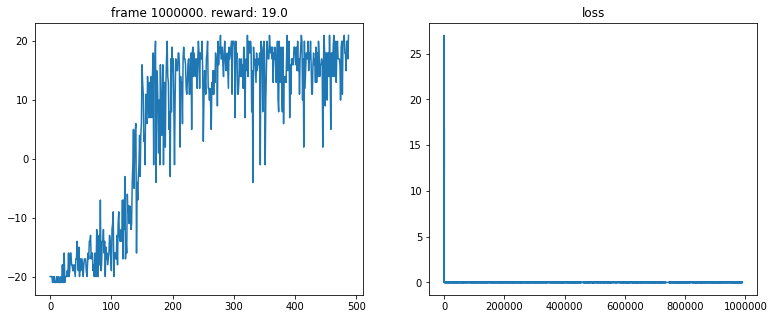

In [86]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)